In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pipeline import build_preprocessing_pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
from scipy.stats import uniform, randint
from metricas import custom_fbeta
from modelos import LogRegWithThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

pd.set_option('display.max_columns', 50)

In [11]:
df = pd.read_csv('data/train_test_network.csv')

# Separação: Dev-Teste

In [12]:
X = df.iloc[:, :-2]
y = df.iloc[:, -2:]

le = LabelEncoder()
y.type = le.fit_transform(y.type)

#X = X.drop(columns=['src_ip', 'src_port', 'dst_ip', 'dst_port'])

Xdev, Xtest, ydev, ytest = train_test_split(X,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=42)

Xdev = Xdev.reset_index(drop=True)
Xtest = Xtest.reset_index(drop=True)
ydev = ydev.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

In [13]:
Xdev.head(5)

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_query,dns_qclass,dns_qtype,dns_rcode,dns_AA,dns_RD,dns_RA,dns_rejected,ssl_version,ssl_cipher,ssl_resumed,ssl_established,ssl_subject,ssl_issuer,http_trans_depth,http_method,http_uri,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice
0,1554271099,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,OTH,0,0,0,0,0,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
1,1554320087,192.168.1.152,41266,192.168.1.190,53,udp,dns,0.275332,0,298,SHR,0,0,0,2,354,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
2,1556203768,192.168.1.30,47508,192.168.1.184,443,tcp,-,60.934442,0,0,S3,0,3,164,2,112,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
3,1556172230,192.168.1.31,47876,176.28.50.165,80,tcp,http,1.315227,271,2177,SF,0,6,591,6,2497,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
4,1556249250,192.168.1.190,25861,203.119.86.101,53,udp,dns,0.031347,47,426,SF,0,1,75,1,454,104.3.in-addr.arpa,1,43,0,F,F,F,F,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-


# Pré-processamento

In [14]:
# http_response_body_len nao e exatamente categorica, mas se considerarmos todas
# as entradas infrequentes como uma coisa so, ela vira categorica

# Textuais que podem ser consideradas categoricas:
#ssl_subject, ssl_issuer, dns_query
#Sinonimo para features textuais - features descritivas
features_textuais = ['http_user_agent', 'http_uri', 'ssl_subject', 'ssl_issuer', 'dns_query']
features_categoricas = ['weird_notice', 'weird_addl', 'weird_name', 'http_resp_mime_types', 'http_orig_mime_types', 'http_status_code', 'http_version',
                        'http_method', 'http_trans_depth', 'ssl_established',
                        'ssl_resumed', 'ssl_cipher', 'ssl_version', 'dns_rejected', 'dns_RA', 'dns_RD', 'dns_AA', 'dns_rcode', 'dns_qtype', 'dns_qclass',
                        'service', 'proto', 'conn_state']
features_numericas = ['duration', 'dst_pkts', 'src_ip_bytes', 'dst_ip_bytes', 'src_bytes', 'http_response_body_len', 'dst_bytes',
                     'missed_bytes', 'src_pkts', 'http_request_body_len']

features_ip = ['src_ip', 'dst_ip']

features_port = ['src_port', 'dst_port']

pipeline = build_preprocessing_pipeline(features_numericas, features_categoricas, features_textuais, features_ip, features_port)

Xdev_pre = pipeline.fit_transform(Xdev)
Xtest_pre = pipeline.transform(Xtest)

c:\Users\igorr\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\igorr\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
len(Xdev_pre.columns)

158

In [17]:
ydev.type

0         5
1         5
2         1
3         3
4         5
         ..
368829    9
368830    5
368831    5
368832    5
368833    6
Name: type, Length: 368834, dtype: int32

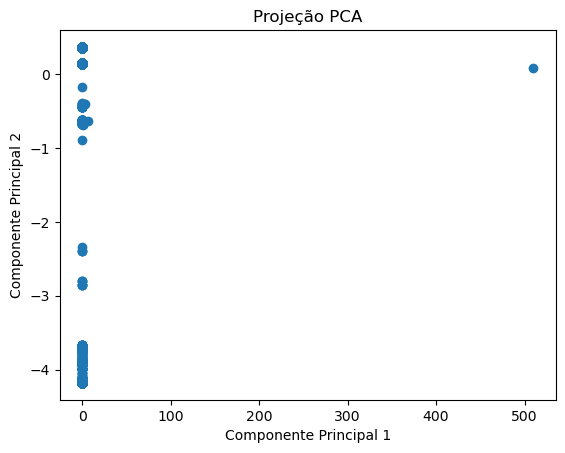

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

mask = ydev.type == 2
X_pca = pca.fit_transform(Xdev_pre[mask])

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Projeção PCA")
plt.show()

# Otimização de Hiperparâmetros

In [ ]:
if True:
    estimator = LogRegWithThreshold()

    param_distributions = {
        'C': np.logspace(-5, 4, 10),
        'max_iter': [250],
        'class_weight': [None, 'balanced'],
        'threshold':uniform(0, 1), # Distribuição uniforme entre 0 e 1
        'random_state': [42]  # Valor fixo
    }

    rscv = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=100,  # Número de combinações aleatórias a serem testadas
        scoring=make_scorer(custom_fbeta, greater_is_better=True),
        cv=5,  # Stratified K-Fold Cross Validation
        verbose=3,
        return_train_score=True,
        random_state=42,  # Garante reprodutibilidade
        n_jobs=2,
        error_score='raise'
    )

    # Treinar o modelo com RandomizedSearchCV
    rscv.fit(Xdev_pre, ydev.label)

    # Exibir os melhores hiperparâmetros encontrados
    print("Melhores hiperparâmetros:", rscv.best_params_)
    print("Melhor score de validação cruzada:", rscv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Melhores hiperparâmetros: {'C': 10000.0, 'class_weight': 'balanced', 'max_iter': 250, 'random_state': 42, 'threshold': 0.5552008115994623}
Melhor score de validação cruzada: 0.9514451846173071


In [30]:
x = rscv.cv_results_['param_threshold']
y = rscv.cv_results_['mean_test_score']
df = pd.DataFrame({'threshold':x, 'mean_test_score':y}).sort_values(by='mean_test_score', ascending=False).head(50)
df
#plt.plot(df['threshold'], df['mean_test_score'])

,threshold,mean_test_score
82,0.555201,0.951445
54,0.427108,0.951401
42,0.427541,0.951401
13,0.450499,0.951320
68,0.592697,0.951316
8,0.431945,0.951311
90,0.580687,0.951296
20,0.546710,0.951284
69,0.369654,0.949042
46,0.539841,0.948974


In [33]:
#Melhores hiperparametros com possibilidade de modelos maiores
#best_params = {'C': 10000.0, 'class_weight': 'balanced', 'max_iter': 250, 'random_state': 42, 'threshold': 0.5539457134966522}
best_params = {'C': 10000.0, 'class_weight': 'balanced', 'max_iter': 250, 'random_state': 42, 'threshold': 0.5552008115994623}

# Seleção de Features

In [34]:
if True:
    estimator = LogRegWithThreshold(**best_params)

    rfecv = RFECV(
        estimator=estimator, 
        step=1,  # Número de features removidas por vez
        cv=5,  # Validação cruzada estratificada
        scoring=make_scorer(custom_fbeta, greater_is_better=True),  # Métrica usada para avaliação
        n_jobs=2,  # Usar todos os núcleos disponíveis
        verbose=3
    )

    # 6. Executar a seleção de features no conjunto de treino
    rfecv.fit(Xdev_pre, ydev.label)

    # 7. Analisar os resultados
    print(f"Número ótimo de features selecionadas: {rfecv.n_features_}")
    print("Features selecionadas:", Xdev_pre.columns[rfecv.support_])

Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
F

In [39]:
print(Xdev_pre.columns[rfecv.support_].to_list())

['src_ip_host', 'src_ip_ipv6', 'src_ip_privado', 'src_ip_multicast', 'dst_ip_host', 'dst_ip_broadcast', 'dst_ip_ipv6', 'dst_ip_privado', 'dst_ip_multicast', 'src_port_well_known', 'src_port_registered', 'src_port_dynamic', 'dst_port_well_known', 'dst_port_registered', 'dst_port_dynamic', 'duration', 'dst_pkts', 'src_ip_bytes', 'dst_ip_bytes', 'src_bytes', 'http_response_body_len', 'missed_bytes', 'http_request_body_len', 'weird_notice_F', 'weird_addl_-', 'weird_addl_46', 'weird_name_-', 'weird_name_DNS_RR_unknown_type', 'weird_name_above_hole_data_without_any_acks', 'weird_name_active_connection_reuse', 'weird_name_bad_TCP_checksum', 'weird_name_bad_UDP_checksum', 'weird_name_connection_originator_SYN_ack', 'weird_name_data_before_established', 'weird_name_inappropriate_FIN', 'http_resp_mime_types_-', 'http_resp_mime_types_application/ocsp-response', 'http_resp_mime_types_application/vnd.ms-cab-compressed', 'http_resp_mime_types_application/xml', 'http_resp_mime_types_image/jpeg', 'htt

In [58]:
#texto = ""
#for i,s in enumerate(Xdev_pre.columns[rfecv.support_].to_list()):

#    if i % 10 == 0:
#        texto += f"'{s}'" + ', ' + '\n'
#    else:
#        texto += f"'{s}'" + ', '
#print(texto)

In [40]:
'''features_selecionadas = [
    'src_ip_host', 'src_ip_ipv6', 'src_ip_privado', 'src_ip_multicast', 'dst_ip_host', 'dst_ip_broadcast', 'dst_ip_ipv6', 'dst_ip_privado', 'dst_ip_multicast', 'src_port_well_known', 'src_port_registered', 
'src_port_dynamic', 'dst_port_well_known', 'dst_port_registered', 'dst_port_dynamic', 'duration', 'dst_pkts', 'src_ip_bytes', 'dst_ip_bytes', 'src_bytes', 'http_response_body_len', 
'missed_bytes', 'http_request_body_len', 'weird_notice_F', 'weird_addl_-', 'weird_addl_46', 'weird_name_-', 'weird_name_DNS_RR_unknown_type', 'weird_name_above_hole_data_without_any_acks', 'weird_name_active_connection_reuse', 'weird_name_bad_TCP_checksum', 
'weird_name_bad_UDP_checksum', 'weird_name_connection_originator_SYN_ack', 'weird_name_data_before_established', 'weird_name_inappropriate_FIN', 'http_resp_mime_types_-', 'http_resp_mime_types_application/ocsp-response', 'http_resp_mime_types_application/vnd.ms-cab-compressed', 'http_resp_mime_types_application/xml', 'http_resp_mime_types_image/jpeg', 'http_resp_mime_types_image/png', 
'http_resp_mime_types_text/html', 'http_resp_mime_types_text/json', 'http_orig_mime_types_-', 'http_status_code_0', 'http_status_code_200', 'http_status_code_206', 'http_status_code_302', 'http_status_code_404', 'http_version_1.1', 'http_method_-', 
'http_method_GET', 'http_trans_depth_-', 'http_trans_depth_1', 'http_trans_depth_2', 'ssl_established_-', 'ssl_established_F', 'ssl_established_T', 'ssl_resumed_-', 'ssl_resumed_F', 'ssl_resumed_T', 
'ssl_cipher_-', 'ssl_cipher_TLS_AES_128_GCM_SHA256', 'ssl_cipher_TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256', 'ssl_cipher_TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384', 'ssl_version_-', 'ssl_version_TLSv12', 'ssl_version_TLSv13', 'dns_rejected_-', 'dns_rejected_F', 'dns_rejected_T', 
'dns_RA_-', 'dns_RA_F', 'dns_RA_T', 'dns_RD_-', 'dns_RD_F', 'dns_RD_T', 'dns_AA_-', 'dns_AA_F', 'dns_AA_T', 'dns_rcode_0', 
'dns_rcode_1', 'dns_rcode_2', 'dns_rcode_3', 'dns_rcode_5', 'dns_qtype_0', 'dns_qtype_1', 'dns_qtype_2', 'dns_qtype_12', 'dns_qtype_28', 'dns_qtype_32', 
'dns_qtype_33', 'dns_qtype_43', 'dns_qtype_48', 'dns_qtype_255', 'dns_qclass_0', 'dns_qclass_1', 'dns_qclass_32769', 'service_-', 'service_dce_rpc', 'service_dhcp', 
'service_dns', 'service_ftp', 'service_gssapi', 'service_http', 'service_smb', 'service_ssl', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 
'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_SF', 'conn_state_SH', 
'conn_state_SHR', 'http_user_agent_infrequent_sklearn', 'http_uri_infrequent_sklearn', 'ssl_subject_infrequent_sklearn', 'ssl_issuer_infrequent_sklearn', 'dns_query_infrequent_sklearn'
]'''

features_selecionadas = ['src_ip_host', 'src_ip_ipv6', 'src_ip_privado', 'src_ip_multicast', 'dst_ip_host', 'dst_ip_broadcast', 'dst_ip_ipv6', 'dst_ip_privado', 'dst_ip_multicast', 'src_port_well_known', 'src_port_registered', 'src_port_dynamic', 'dst_port_well_known', 'dst_port_registered', 'dst_port_dynamic', 'duration', 'dst_pkts', 'src_ip_bytes', 'dst_ip_bytes', 'src_bytes', 'http_response_body_len', 'missed_bytes', 'http_request_body_len', 'weird_notice_F', 'weird_addl_-', 'weird_addl_46', 'weird_name_-', 'weird_name_DNS_RR_unknown_type', 'weird_name_above_hole_data_without_any_acks', 'weird_name_active_connection_reuse', 'weird_name_bad_TCP_checksum', 'weird_name_bad_UDP_checksum', 'weird_name_connection_originator_SYN_ack', 'weird_name_data_before_established', 'weird_name_inappropriate_FIN', 'http_resp_mime_types_-', 'http_resp_mime_types_application/ocsp-response', 'http_resp_mime_types_application/vnd.ms-cab-compressed', 'http_resp_mime_types_application/xml', 'http_resp_mime_types_image/jpeg', 'http_resp_mime_types_image/png', 'http_resp_mime_types_text/html', 'http_resp_mime_types_text/json', 'http_orig_mime_types_-', 'http_status_code_0', 'http_status_code_200', 'http_status_code_206', 'http_status_code_302', 'http_status_code_404', 'http_version_1.1', 'http_method_-', 'http_method_GET', 'http_trans_depth_-', 'http_trans_depth_1', 'http_trans_depth_2', 'ssl_established_-', 'ssl_established_F', 'ssl_established_T', 'ssl_resumed_-', 'ssl_resumed_F', 'ssl_resumed_T', 'ssl_cipher_-', 'ssl_cipher_TLS_AES_128_GCM_SHA256', 'ssl_cipher_TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256', 'ssl_cipher_TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384', 'ssl_version_-', 'ssl_version_TLSv12', 'ssl_version_TLSv13', 'dns_rejected_-', 'dns_rejected_F', 'dns_rejected_T', 'dns_RA_-', 'dns_RA_F', 'dns_RA_T', 'dns_RD_-', 'dns_RD_F', 'dns_RD_T', 'dns_AA_-', 'dns_AA_F', 'dns_AA_T', 'dns_rcode_0', 'dns_rcode_1', 'dns_rcode_2', 'dns_rcode_3', 'dns_rcode_5', 'dns_qtype_0', 'dns_qtype_1', 'dns_qtype_2', 'dns_qtype_12', 'dns_qtype_28', 'dns_qtype_32', 'dns_qtype_33', 'dns_qtype_43', 'dns_qtype_48', 'dns_qtype_255', 'dns_qclass_0', 'dns_qclass_1', 'dns_qclass_32769', 'service_-', 'service_dce_rpc', 'service_dhcp', 'service_dns', 'service_ftp', 'service_gssapi', 'service_http', 'service_smb', 'service_ssl', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR', 'http_user_agent_infrequent_sklearn', 'http_uri_infrequent_sklearn', 'ssl_subject_infrequent_sklearn', 'ssl_issuer_infrequent_sklearn', 'dns_query_infrequent_sklearn']

In [41]:
len(features_selecionadas)

127

# Treinamento

In [42]:
model = LogRegWithThreshold(**best_params)

Xtrain, Xval, ytrain, yval = train_test_split(Xdev_pre[features_selecionadas], ydev, test_size=0.2, random_state=42)

model.fit(Xdev_pre, ydev.label)

LogRegWithThreshold(C=10000.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=250, multi_class='deprecated', n_jobs=None,
                    penalty='l2', random_state=42, solver='lbfgs',
                    threshold=0.5552008115994623, tol=0.0001, verbose=0,
                    warm_start=False)

In [41]:
model = LogRegWithThreshold(**best_params)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_macro = []
accuracy = []
for train_index, val_index in tqdm(skf.split(Xdev_pre, ydev.label)):
    X_train, X_val = Xdev_pre.loc[train_index, features_selecionadas], Xdev_pre.loc[val_index, features_selecionadas]
    y_train, y_val = ydev.loc[train_index, 'label'], ydev.loc[val_index, 'label']
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    f1_macro.append(f1_score(y_val, y_val_pred, average='macro'))
    accuracy.append(accuracy_score(y_val, y_val_pred))

print(f'Acurácia: {np.mean(accuracy):.4f} (média); {np.std(accuracy):.4f} (desvio padrão)')
print(f'F1-score: {np.mean(f1_macro):.4f} (média); {np.std(f1_macro):.4f} (desvio padrão)')


0it [00:00, ?it/s]


KeyboardInterrupt: 

# Teste

In [43]:
model = LogRegWithThreshold(**best_params)
model.fit(Xdev_pre[features_selecionadas], ydev.label)

ytest_pred = model.predict(Xtest_pre[features_selecionadas])

In [46]:
print('Acurácia:', accuracy_score(ytest.label, ytest_pred))
print('F1-score:', f1_score(ytest.label, ytest_pred))
print('Fbeta-score:', custom_fbeta(ytest.label, ytest_pred))
print('Precision:', precision_score(ytest.label, ytest_pred))
print('Recall:', recall_score(ytest.label, ytest_pred))

Acurácia: 0.9663373423418539
F1-score: 0.9518177020272578
Fbeta-score: 0.9518293015553393
Precision: 0.9517586067736628
Recall: 0.9518768046198267


In [61]:
print('Acurácia:', accuracy_score(ytest.label, ytest_pred))
print('F1-score:', f1_score(ytest.label, ytest_pred))
print('Fbeta-score:', custom_fbeta(ytest.label, ytest_pred))
print('Precision:', precision_score(ytest.label, ytest_pred))
print('Recall:', recall_score(ytest.label, ytest_pred))

Acurácia: 0.9666301554078235
F1-score: 0.9522627488092837
Fbeta-score: 0.9523758477023426
Precision: 0.9516869263210121
Recall: 0.9528392685274302


In [62]:
TP = (ytest.label[ytest.label == 1] == ytest_pred[ytest.label == 1]).sum()
TN = (ytest.label[ytest.label == 0] == ytest_pred[ytest.label == 0]).sum()
FP = (ytest.label[ytest.label == 0] != ytest_pred[ytest.label == 0]).sum()
FN = (ytest.label[ytest.label == 1] != ytest_pred[ytest.label == 1]).sum()

In [63]:
(TP + TN)/(TP + TN + FP + FN)

0.9666301554078235

In [64]:
print('TP:', TP)
print('TN:', TN)
print('FP:', FP)
print('FN:', FN)

TP: 30690
TN: 58442
FP: 1558
FN: 1519


In [48]:
from sklearn.preprocessing import LabelEncoder

classes = sorted(ytest.type.unique())
metrics = {'Precision':[], 'Recall':[], 'Accuracy':[], 'F1score':[]}
for c in classes:
    mask_c = ytest.type == c
    pred = model.predict(Xtest_pre[features_selecionadas])[mask_c]
    real = ytest.label[mask_c]

    metrics['Precision'].append(precision_score(real, pred))
    metrics['Recall'].append(recall_score(real, pred))
    metrics['Accuracy'].append(accuracy_score(real, pred))
    metrics['F1score'].append(f1_score(real, pred))

pd.DataFrame(metrics, index=le.classes_).round(4)*100

c:\Users\igorr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Precision,Recall,Accuracy,F1score
backdoor,100.0,99.82,99.82,99.91
ddos,100.0,98.80,98.80,99.40
dos,100.0,98.88,98.88,99.43
injection,100.0,96.25,96.25,98.09
mitm,100.0,66.99,66.99,80.23
normal,0.0,0.00,97.41,0.00
password,100.0,99.68,99.68,99.84
ransomware,100.0,70.38,70.38,82.61
scanning,100.0,99.80,99.80,99.90
xss,100.0,99.38,99.38,99.69


In [80]:
le.classes_

array(['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal',
       'password', 'ransomware', 'scanning', 'xss'], dtype=object)

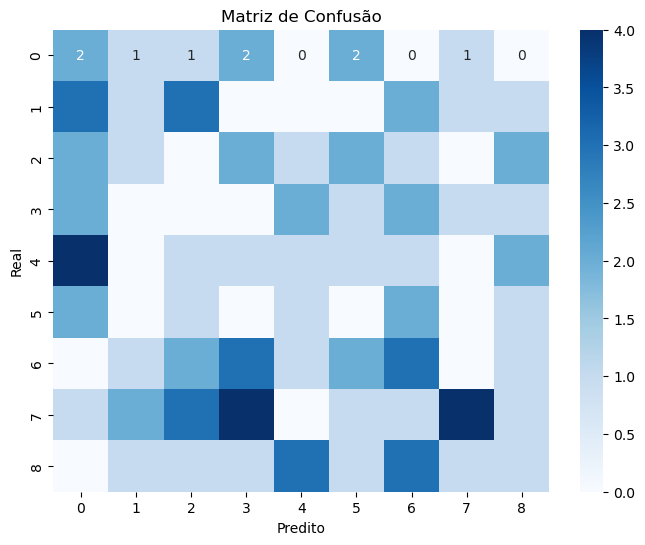

In [79]:
from sklearn.metrics import confusion_matrix

# Exemplo: Gerando uma matriz de confusão aleatória para 9 classes
np.random.seed(42)
y_true = np.random.randint(0, 9, 100)  # Valores verdadeiros
y_pred = np.random.randint(0, 9, 100)  # Predições do modelo

# Criar matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Criar o gráfico com seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(9), yticklabels=range(9))
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()